In [1]:

import numpy as np
using_numpy = True

from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

In [2]:
!curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o /tmp/data.tar.gz
!tar -x -z -f /tmp/data.tar.gz
!rm -f /tmp/data.tar.gz

In [3]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")

In [4]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)


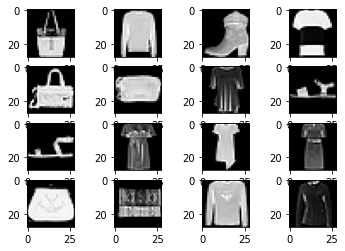

In [5]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        img = trainxs[np.random.randint(0, len(trainxs))]
        if not using_numpy:
            img = img.get()
        axarr[i, j].imshow(img)

## 3.1 Analytical Gradients

Find on overleaf

## 3.2 Implementing Gradient Check

In [6]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

def loss(yhat, y):
    if yhat in (0, 1):
        return np.array([[0]])
    return (-y * np.log(yhat)) - ((1 - y) * np.log(1 - yhat))

In [7]:
def forward(params, x):
    """Compute Forward Pass"""
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["W2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    forward_res["z3"] = params["W3"] @ forward_res["a2"] + params["b3"]
    forward_res["a3"] = sigmoid(forward_res["z3"])
    
    return forward_res

def backprop(x, y, params):
    """Compute Gradients"""
    x = x.reshape(28**2, 1)
    
    fwd_pass = forward(params, x)
    
    # Backwards Pass
    dL_dz3 = (fwd_pass["a3"] - y)
    dL_dz2 = dL_dz3.dot(params["W3"]).T * sigmoid_d(fwd_pass["z2"])
    dL_dz1 = dL_dz2.T.dot(params["W2"]).T * sigmoid_d(fwd_pass["z1"])
    
    grad = {}
    grad["W3"] = dL_dz3.dot(fwd_pass["a2"].T)
    grad["b3"] = dL_dz3
    grad["W2"] = dL_dz2.dot(fwd_pass["a1"].T)
    grad["b2"] = dL_dz2
    grad["W1"] = dL_dz1.dot(x.T)
    grad["b1"] = dL_dz1

    return grad

In [13]:
def predict_raw(x, params):
    """Get raw model activation for given training sample"""
    forward_res = forward(params, x)
    return forward_res["a3"]

def predict_class(yhat):
    """Get class prediction for given activation"""
    if yhat >= 0.5:
        return 1
    return 0

In [15]:
# Finite Differences Helper functions
def init_empty_params(m):
    grad = {}
    grad["W3"] = np.zeros_like(m["W3"])
    grad["b3"] = np.zeros_like(m["b3"])
    grad["W2"] = np.zeros_like(m["W2"])
    grad["b2"] = np.zeros_like(m["b2"])
    grad["W1"] = np.zeros_like(m["W1"])
    grad["b1"] = np.zeros_like(m["b1"])
    return grad

def flatten(m):
    toflatten = (m["W1"], m["b1"], m["W2"], m["b2"], m["W3"], m["b3"])
    vec = np.zeros(sum([x.size for x in toflatten]))
    offset = 0
    for param in toflatten:
        vec[offset:offset + param.size] = param.reshape(param.size)
        offset += param.size
    return vec

def unflatten(m, vec):
    params = (m["W1"], m["b1"], m["W2"], m["b2"], m["W3"], m["b3"])
    offset = 0
    for param in params:
        param[:] = vec[offset:offset + param.size].reshape(param.shape)
        offset += param.size
    return m

In [32]:
def run_fd(x, y, m):
    eps = 1e-6
    vecm = flatten(m)
    gradm = init_empty_params(m)
    vecgradm = flatten(gradm)
    for i in range(vecm.size):
        wi = vecm[i]
        vecm[i] += eps
        yhat = predict_raw(x, unflatten(init_empty_params(m), vecm))
        u = loss(yhat, y)
        vecm[i] = wi
        vecm[i] -= eps
        yhat = predict_raw(x, unflatten(init_empty_params(m), vecm))
        l = loss(yhat, y)
        vecgradm[i] = ((u - l) / (2 * eps))
        
        vecm[i] = wi
    return unflatten(gradm, vecgradm)

def compare_gradients(xs, ys, i):
    x, y = xs[i], ys[i]
    img_size, h2, h1, out_size = 784, 199, 19, 1
    params = {
        "W1": np.random.randn(h1, img_size) * np.sqrt(1 / img_size),
        "b1": np.zeros((h1, 1)),
        "W2": np.random.randn(h2, h1) * np.sqrt(1 / h1),
        "b2": np.zeros((h2, 1)),
        "W3": np.random.randn(out_size, h2) * np.sqrt(1 / h2),
        "b3": np.zeros((out_size, 1))
    }
    bp_an = backprop(x, y, params)
    bp_fd = run_fd(x, y, params)
    for k in bp_an:
        print(np.allclose(bp_an[k], bp_fd[k]))
compare_gradients(trainxs, trainys, 420)
compare_gradients(trainxs, trainys, 42)

True
True
True
True
True
True
True
True
True
True
True
True


## 3.3 Implementing the algorithm

In [24]:
def nvalidate(xs, ys, params):
    """Returns (Dataset Loss, Dataset Accuracy)"""
    l, accuracy = 0, 0
    nData = xs.shape[0]
    for i in range(nData):
        yhat = predict_raw(xs[i], params) # Raw activation
        y_pred = predict_class(yhat) # Class prediction (binary)
        # Add Log Likelihood Loss
        if yhat not in (0, 1):
            l += (-ys[i] * np.log(yhat)) - ((1 - ys[i]) * np.log(1 - yhat))
        if y_pred == ys[i]:
            accuracy += 1
    return l.item() / nData, accuracy / nData

In [25]:
def mlp(xs, ys, devxs, devys, n_epochs=3, learning_rate=0.1, momentum=0, batch_size=0, h1=19, h2=199):
    """Initialize and train model on a dataset, outputting validation set accuracy/loss"""
    img_size = 28**2
    out_size = 1
    nData = xs.shape[0]

    lr = learning_rate
    a = momentum # alpha

    # Enable Full Batch (set batch size 1 for s.g.d.)
    if batch_size == 0:
        batch_size = nData

    print("nData:", nData, "Hidden Layer 1 size:", h1, "Hidden Layer 2 size:", h2, "Learning Rate:", lr, "Momentum:", momentum, "Batch Size:", batch_size)

    # Initialize training metadata containers
    epochs = []
    t_losses, v_losses = [], []
    t_accs, v_accs = [], []

    # Initialize model parameters
    params = {"W1": np.random.randn(h1, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h1, 1)),
              "W2": np.random.randn(h2, h1) * np.sqrt(1 / h1),
              "b2": np.zeros((h2, 1)),
              "W3": np.random.randn(out_size, h2) * np.sqrt(1 / h2),
              "b3": np.zeros((out_size, 1))}
    
    # Initialize Grad vector
    grad = {}
    # Initialize Update Vector nu
    v = {
        "W1": np.zeros_like(params["W1"]),
        "b1": np.zeros_like(params["b1"]),
        "W2": np.zeros_like(params["W2"]),
        "b2": np.zeros_like(params["b2"]),
        "W3": np.zeros_like(params["W3"]),
        "b3": np.zeros_like(params["b3"]),
    }
    
    for epoch in range(n_epochs):
        epochs.append(epoch)
        print("----------------------------------\nEpoch:", epoch)
        v_loss, v_acc = nvalidate(devxs, devys, params)
        v_accs.append(v_acc)
        v_losses.append(v_loss)
        print("Val Acc:", v_acc, "Val Loss:", v_loss)
        
        # Randomly shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]

        # Get array of arrays containing batch_size array indices
        batch_indices = np.split(np.arange(nData), (nData // batch_size))
        
        for batch in batch_indices:
            # Initialize gradients to zero
            grad["W3"] = np.zeros_like(params["W3"])
            grad["b3"] = np.zeros_like(params["b3"])
            grad["W2"] = np.zeros_like(params["W2"])
            grad["b2"] = np.zeros_like(params["b2"])
            grad["W1"] = np.zeros_like(params["W1"])
            grad["b1"] = np.zeros_like(params["b1"])
            
            for i in batch:
                grad_i = backprop(trainxs_shuffled[i], trainys_shuffled[i], params)
                
                grad["W3"] += grad_i["W3"] / batch_size
                grad["b3"] += grad_i["b3"] / batch_size
                grad["W2"] += grad_i["W2"] / batch_size
                grad["b2"] += grad_i["b2"] / batch_size
                grad["W1"] += grad_i["W1"] / batch_size
                grad["b1"] += grad_i["b1"] / batch_size
  
            v["W1"] = a * v["W1"] + (1-a) * grad["W1"]
            v["b1"] = a * v["b1"] + (1-a) * grad["b1"]
            v["W2"] = a * v["W2"] + (1-a) * grad["W2"]
            v["b2"] = a * v["b2"] + (1-a) * grad["b2"]
            v["W3"] = a * v["W3"] + (1-a) * grad["W3"]
            v["b3"] = a * v["b3"] + (1-a) * grad["b3"]  
            
            params["W1"] -= lr * v["W1"]
            params["b1"] -= lr * v["b1"]
            params["W2"] -= lr * v["W2"]
            params["b2"] -= lr * v["b2"]
            params["W3"] -= lr * v["W3"]
            params["b3"] -= lr * v["b3"]
        
        
    return epochs, t_losses, t_accs, v_losses, v_accs, params

In [26]:
epochs, t_losses, t_accs, v_losses, v_accs, _ = mlp(
    trainxs, trainys, 
    devxs, devys,
    n_epochs=10,
    learning_rate=0.1,
    momentum=0.2,
    batch_size=1,
    h1=19,
    h2=199,
)

nData: 12000 Hidden Layer 1 size: 19 Hidden Layer 2 size: 199 Learning Rate: 0.1 Momentum: 0.2 Batch Size: 1
----------------------------------
Epoch: 0
Val Acc: 0.505 Val Loss: 0.8674586675816987
----------------------------------
Epoch: 1
Val Acc: 0.973 Val Loss: 0.09002599779472187
----------------------------------
Epoch: 2
Val Acc: 0.981 Val Loss: 0.06929391742685712
----------------------------------
Epoch: 3
Val Acc: 0.978 Val Loss: 0.08106739301322857
----------------------------------
Epoch: 4
Val Acc: 0.971 Val Loss: 0.085061978245318
----------------------------------
Epoch: 5
Val Acc: 0.976 Val Loss: 0.08652145653802906
----------------------------------
Epoch: 6
Val Acc: 0.976 Val Loss: 0.09247030260059583
----------------------------------
Epoch: 7
Val Acc: 0.968 Val Loss: 0.08949003311421755
----------------------------------
Epoch: 8
Val Acc: 0.931 Val Loss: 0.14250817105986166
----------------------------------
Epoch: 9
Val Acc: 0.96 Val Loss: 0.09241884335184866


## 3.4 Training model to convergence

Convergence is defined as no improvement in validation loss over 3 consecutive parameter updates.

## 3.5 Loss plot for training set

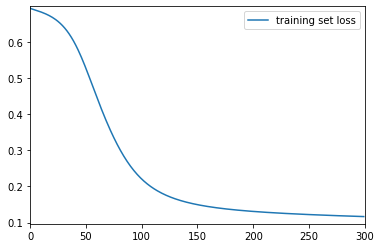

In [ ]:
plt.axis([0, epoch, min(loss_training) - 0.02, max(loss_training) + 0.005])
plt.plot(loss_training, label='training set loss')
plt.legend(loc='upper right')

## 3.6 Accuracy plot for training set

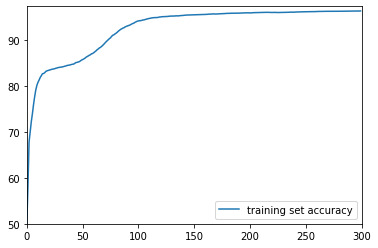

In [ ]:
plt.axis([0, epoch, min(accuracy_training), max(accuracy_training) + 1])
plt.plot(accuracy_training, label='training set accuracy')
plt.legend(loc='lower right')

## 3.7 Accuracy for best epoch

In [ ]:
ind = accuracy_validation.index(max(accuracy_validation))

In [ ]:
print("Best epoch =", ind)
print("Accuracy on training set =", accuracy_training[ind])
print("Accuracy on validation set =", accuracy_validation[ind])

Best epoch = 271
Accuracy on training set = 96.34166666666667
Accuracy on validation set = 96.6


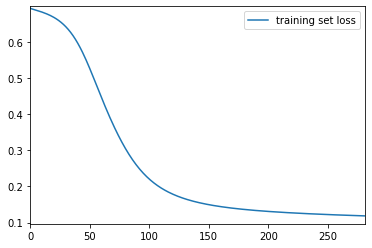

In [ ]:
plt.axis([0, epoch-19, min(loss_training) - 0.02, max(loss_training) + 0.005])
plt.plot(loss_training, label='training set loss')
plt.legend(loc='upper right')

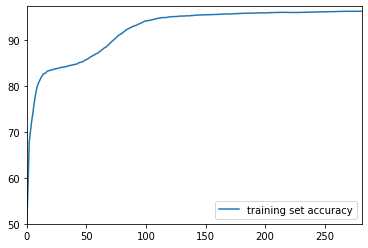

In [ ]:
plt.axis([0, epoch-19, min(accuracy_training), max(accuracy_training) + 1])
plt.plot(accuracy_training, label='training set accuracy')
plt.legend(loc='lower right')